In [1]:
import numpy as np
import os
import pandas as pd
import h5py
from scipy.io import loadmat
import socket
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
warnings.simplefilter("ignore", category=RuntimeWarning)

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['ALI_evoked'] = os.path.join(p['EEGfiles'], 'ALI_evoked_basecorr1.mat')
p['ALI_induced'] = os.path.join(p['EEGfiles'], 'ALI_induced_basecorr1.mat')
p['subjectALI_evoked'] = os.path.join(p['EEGfiles'], 'subjectALI_evoked.mat')
p['ALI_evoked_npz'] = os.path.join(p['EEGfiles'], 'ALI_evoked_basecorr1.npz')
p['ALI_induced_npz'] = os.path.join(p['EEGfiles'], 'ALI_induced_basecorr1.npz')
p['subjectALI_evoked_npz'] = os.path.join(p['EEGfiles'], 'subjectALI_evoked.npz')
p['mCDA'] = os.path.join(p['EEGfiles'], 'CDA.mat')
p['training_data'] = os.path.join(p['EEGfiles'], 'training_data.npy')
# Load up summary meta-data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))
All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}

# Load up behavioral data
df_behav = pd.read_csv(p['df_fname'])
df_behav['trl_idx'] = df_behav['rnum'] * df_behav['tnum']

In [3]:
# Load up ALI evoked and induced
if os.path.exists(p['ALI_evoked_npz']):
    ALI_evoked_data = np.load(p['ALI_evoked_npz'])
    X_evoked = ALI_evoked_data['arr_0']
    y_evoked = ALI_evoked_data['arr_1']
    time_array = ALI_evoked_data['arr_2']
else:
    with h5py.File(p['ALI_evoked'], 'r') as f:
        X_evoked = np.array(f['mALI']).T
        y_evoked = np.array(f['trl_mat']).T
    with h5py.File(os.path.join(p['EEGfiles'], 'sub01/day01/sub01_day01_TFR_evoked.mat')) as f:
        time_array = np.array(f['POW']['pin']['time'])
    np.savez(p['ALI_evoked_npz'], X_evoked, y_evoked, time_array)

if os.path.exists(p['ALI_induced_npz']):
    ALI_induced_data = np.load(p['ALI_induced_npz'])
    X_induced = ALI_induced_data['arr_0']
    y_induced = ALI_induced_data['arr_1']
    time_array = ALI_induced_data['arr_2']
else:
    with h5py.File(p['ALI_induced'], 'r') as f:
        X_induced = np.array(f['mALI']).T
        y_induced = np.array(f['trl_mat']).T
    with h5py.File(os.path.join(p['EEGfiles'], 'sub01/day01/sub01_day01_TFR_evoked.mat')) as f:
        time_array = np.array(f['POW']['pin']['time'])
    np.savez(p['ALI_induced_npz'], X_induced, y_induced, time_array)

if os.path.exists(p['subjectALI_evoked_npz']):
    subjectALI_evoked_data = np.load(p['subjectALI_evoked_npz'])
    X_subject_evoked = subjectALI_evoked_data['arr_0']
    y_subject_evoked = subjectALI_evoked_data['arr_1']
else:
    with h5py.File(p['subjectALI_evoked'], 'r') as f:
        X_subject_evoked = np.array(f['subjectALI']).T
        y_subject_evoked = np.array(f['trl_mat']).T
    np.savez(p['subjectALI_evoked_npz'], X_subject_evoked, y_subject_evoked)

yevoked_df = pd.DataFrame(y_evoked, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')
yinduced_df = pd.DataFrame(y_induced, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')

# Create data with just trials that were retained after both behavioral and EEG trial-rejection
master_df = pd.merge(df_behav.reset_index(), yevoked_df.drop(columns=['istms']).reset_index(), on=['subjID', 'day', 'trl_idx'], how='inner', indicator=True)
idx_behav = master_df['index_x'].tolist()
idx_ALI = master_df['index_y'].tolist()
master_df = master_df.drop(columns=['index_x', 'Unnamed: 0', 'index_y', '_merge'])
Xcommon_evoked = X_evoked[idx_ALI, :]
Xcommon_induced = X_induced[idx_ALI, :]

# Make a list of different trial-types
trial_types = ['pin', 'pout', 'ain', 'aout']
tms_cond = [0, 1]

In [3]:
# Compute ALI average per subject
sub_list = yevoked_df['subjID'].unique()
ALI_evoked = np.zeros((len(tms_cond), len(trial_types), len(sub_list), len(time_array)))
ALI_induced = np.zeros((len(tms_cond), len(trial_types), len(sub_list), len(time_array)))
for ii, cond in enumerate(tms_cond):
    for jj, t_type in enumerate(trial_types):
        idx = yevoked_df.loc[(yevoked_df['istms'] == cond) & (yevoked_df['t_type'] == jj+1)].index
        this_df = yevoked_df.iloc[idx].reset_index(drop=True)
        this_X_evoked = X_evoked[idx, :]
        this_X_induced = X_induced[idx, :]
        for kk in range(len(sub_list)):
            this_idx = this_df.index[this_df['subjID'] == sub_list[kk]].tolist()
            ALI_evoked[ii, jj, kk, :] = np.nanmean(this_X_evoked[this_idx, :], 0)
            ALI_induced[ii, jj, kk, :] = np.nanmean(this_X_induced[this_idx, :], 0)

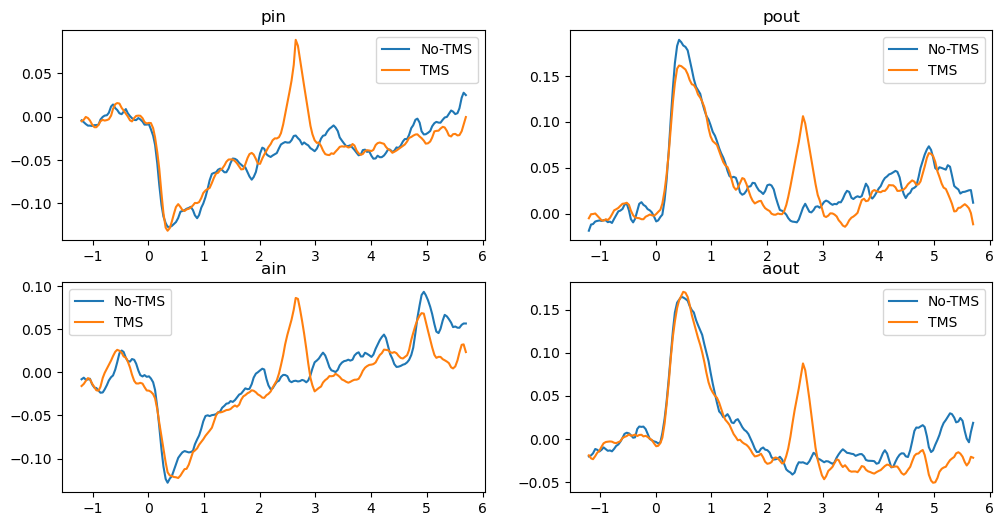

In [8]:
## Let us plot ALI_evoked across subjects for No-TMS and TMS conditions for proin and proout trials

plt.figure(figsize=(12, 6))
for ii, cond in enumerate(tms_cond):
    for jj, t_type in enumerate(trial_types):
        plt.subplot(2, 2, jj+1)
        plt.plot(time_array, np.nanmean(ALI_evoked[ii, jj, :, :], 0), label='TMS' if cond == 1 else 'No-TMS')
        plt.title(t_type)
        plt.legend()

In [61]:
from scipy.stats import ttest_ind

In [67]:
# Now let's compare the ALI_evoked in the early and late delay, early delay being 500-1500ms and late delay being 2500-3500ms
early_delay = np.where((time_array >= 0.5) & (time_array <= 1.5))[0]
late_delay = np.where((time_array >= 2.5) & (time_array <= 3.5))[0]

# Find idx for good subjects
good_subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]
good_subs_idx = [np.where(sub_list == sub)[0][0] for sub in good_subs]
# print(good_subs_idx)
ALI_evoked_early = ALI_evoked[:, :, :, early_delay]
ALI_evoked_late = ALI_evoked[:, :, :, late_delay]

ALI_evoked_early = ALI_evoked_early[:, :, good_subs_idx, :]
ALI_evoked_late = ALI_evoked_late[:, :, good_subs_idx, :]

# Segregate for No TMS and TMS for pin
ALI_evoked_early_notms = ALI_evoked_early[0, 0, :, :] #-ALI_evoked_early[0, 1, :, :]
ALI_evoked_early_tms = ALI_evoked_early[1, 0, :, :] 
ALI_evoked_late_notms = ALI_evoked_late[0, 0, :, :] #-ALI_evoked_late[0, 1, :, :]
ALI_evoked_late_tms = ALI_evoked_late[1, 0, :, :] 

ALI_early_notms_mean = np.mean(ALI_evoked_early_notms, 1)
ALI_early_tms_mean = np.mean(ALI_evoked_early_tms, 1)
ALI_late_notms_mean = np.mean(ALI_evoked_late_notms, 1)
ALI_late_tms_mean = np.mean(ALI_evoked_late_tms, 1)

import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

subjects = np.arange(1, len(good_subs)+1)

# Repeat Subject IDs for each condition and time point
subjects_replicated = np.tile(subjects, 4)

time_labels = np.concatenate([np.tile(['Early'], len(good_subs)), np.tile(['Early'], len(good_subs)), 
                              np.tile(['Late'], len(good_subs)), np.tile(['Late'], len(good_subs))])
condition_labels = np.concatenate([np.tile(['No TMS'], len(good_subs)), np.tile(['TMS'], len(good_subs)), 
                                   np.tile(['No TMS'], len(good_subs)), np.tile(['TMS'], len(good_subs))])
# time_labels = np.tile([''])
# Create the DataFrame
data = pd.DataFrame({
    'ALI': np.concatenate([ALI_early_notms_mean, ALI_early_tms_mean, ALI_late_notms_mean, ALI_late_tms_mean]),
    'Time': time_labels,
    'Condition': condition_labels,
    'Subject': subjects_replicated
})

# Perform repeated-measures ANOVA
rm_anova = AnovaRM(data, 'ALI', 'Subject', within=['Time', 'Condition']).fit()
print(rm_anova)


t_statistic, p_value = ttest_ind(ALI_late_tms_mean, ALI_late_notms_mean)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
Time           43.8459 1.0000 14.0000 0.0000
Condition       0.9508 1.0000 14.0000 0.3461
Time:Condition  0.3720 1.0000 14.0000 0.5517

T-Statistic: 0.8766245572162114
P-Value: 0.3881499079929742


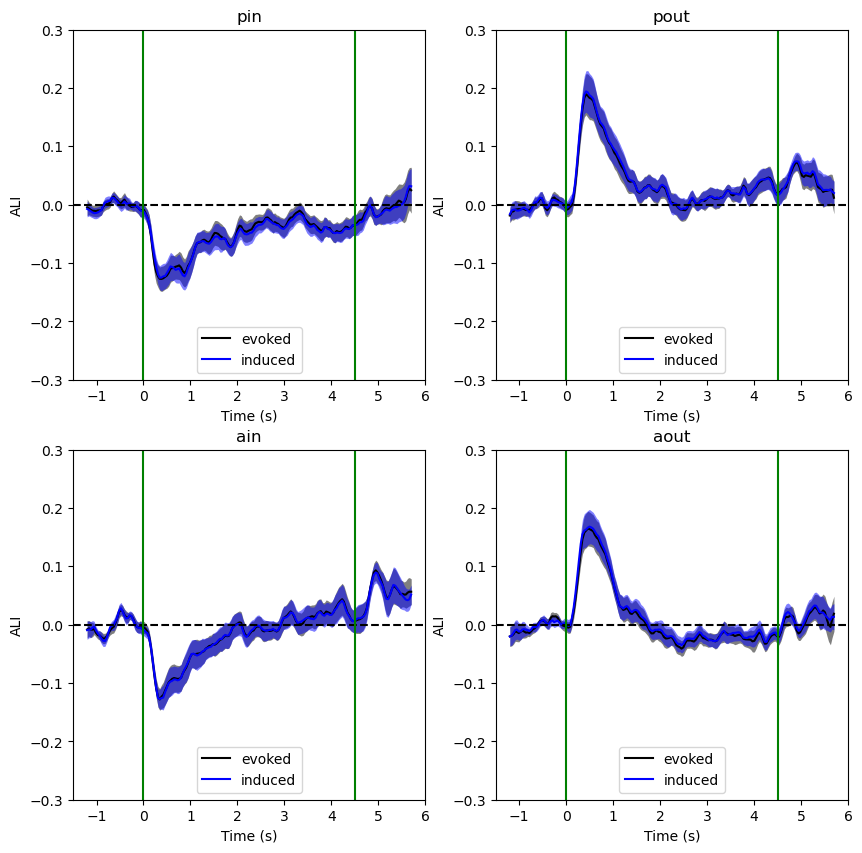

In [4]:
## ALIs for evoked vs induced for No TMS
lim_val = 0.3
f, axs = plt.subplots(2, 2, figsize=(10, 10))
for jj, ax in zip([0,1,2,3], axs.ravel()):
    y1 = np.nanmean(ALI_evoked[0, jj, :, :], 0)
    y2 = np.nanmean(ALI_induced[0, jj, :, :], 0)
    y1_err = np.nanstd(ALI_evoked[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    y2_err = np.nanstd(ALI_induced[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y1, 'k-', label='evoked')
    ax.plot(time_array, y2, 'b-', label='induced')
    ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='k')
    ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='b')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[jj])

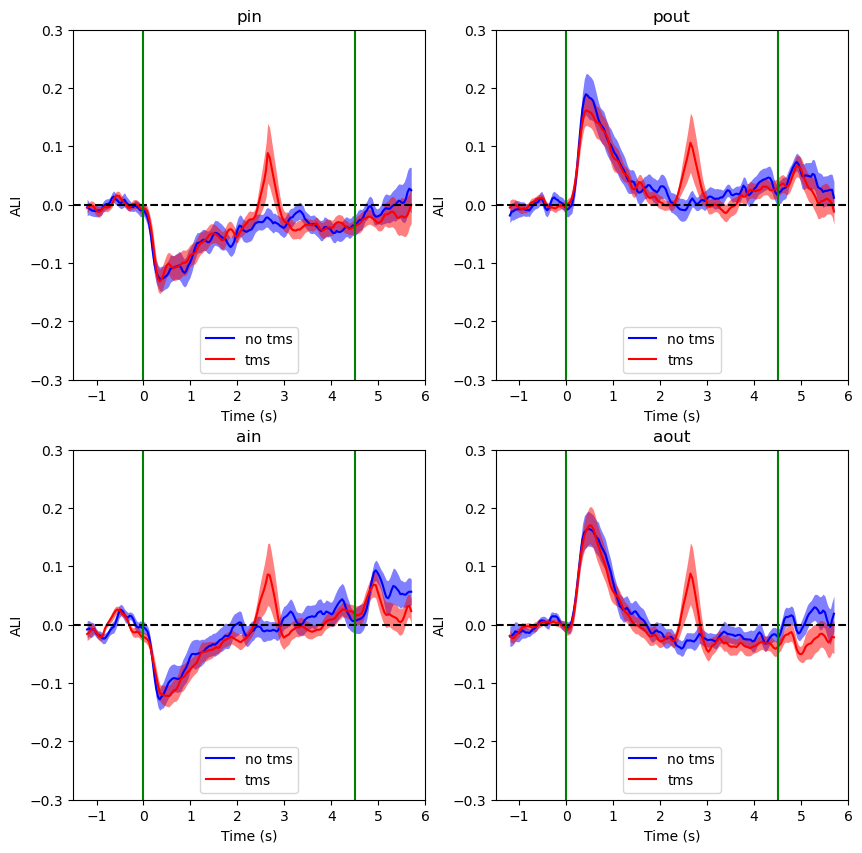

In [5]:
## ALIs for evoked for No TMS vs TMS
lim_val = 0.3
f, axs = plt.subplots(2, 2, figsize=(10, 10))
for jj, ax in zip([0,1,2,3], axs.ravel()):
    y1 = np.nanmean(ALI_evoked[0, jj, :, :], 0)
    y2 = np.nanmean(ALI_evoked[1, jj, :, :], 0)
    y1_err = np.nanstd(ALI_evoked[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    y2_err = np.nanstd(ALI_evoked[1, jj, :, :], 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y1, 'b-', label='no tms')
    ax.plot(time_array, y2, 'r-', label='tms')
    ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='b')
    ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='r')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[jj])

## ALI for high and low saccade errors

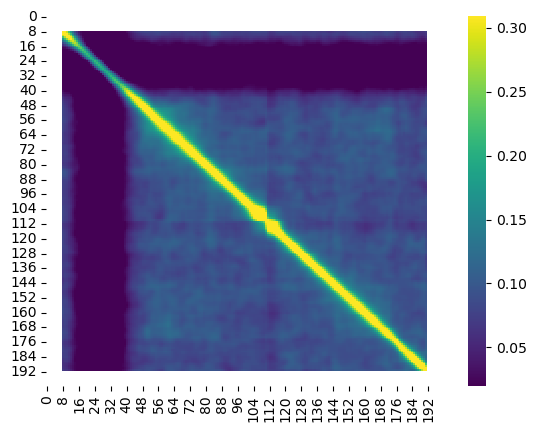

In [5]:
b_type = 'pro'
cond = 1
if b_type == 'pro':
    tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 0) | (master_df['t_type'] == 1))]
    idx_in = master_df.loc[(master_df['istms'] == cond) & (master_df['t_type'] == 1)].index
    idx_out = master_df.loc[(master_df['istms'] == cond) & (master_df['t_type'] == 2)].index
else:
    tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 2) | (master_df['t_type'] == 3))]
    idx_in = master_df.loc[(master_df['istms'] == cond) & (master_df['t_type'] == 3)].index
    idx_out = master_df.loc[(master_df['istms'] == cond) & (master_df['t_type'] == 4)].index
this_Xevoked_in = Xcommon_induced[idx_in, :]
this_Xevoked_out = -Xcommon_induced[idx_out, :]     
this_Xevoked = np.concatenate((this_Xevoked_in, this_Xevoked_out), axis = 0)  
corr = (this_Xevoked.T @ this_Xevoked) / np.shape(this_X_evoked)[0]
matrix = np.triu(np.ones_like(corr))
plt.figure()

sns.heatmap(corr, annot=False, robust=True, cmap="viridis", vmin=0.02)
plt.show()

In [6]:
# Compute ALI average per subject
sub_list = yevoked_df['subjID'].unique()
block_types = ['pro', 'anti']

ALI_lowerr = np.zeros((len(tms_cond), len(block_types), len(sub_list), len(time_array)))
ALI_higherr = np.zeros((len(tms_cond), len(block_types), len(sub_list), len(time_array)))
for ii, cond in enumerate(tms_cond):
    for jj, b_type in enumerate(block_types):
        if b_type == 'pro':
            tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 0) | (master_df['t_type'] == 1))]
            idx = master_df.loc[(master_df['istms'] == cond) & ((master_df['t_type'] == 0) | (master_df['t_type'] == 1))].index
        else:
            tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 2) | (master_df['t_type'] == 3))]
            idx = master_df.loc[(master_df['istms'] == cond) & ((master_df['t_type'] == 2) | (master_df['t_type'] == 3))].index
        this_Xevoked = X_evoked[idx, :]
        
        for kk in range(len(sub_list)):
            this_idx = this_df.index[this_df['subjID'] == sub_list[kk]].tolist()
            sub_df = tdf[]
            low_thresh = np.quantile(tdf['ierr'], 0.25)
            high_thresh = np.quantile(tdf['ierr'], 0.75)
            good_idx = np.where(tdf['ierr'] <= low_thresh)
            bad_idx = np.where(tdf['ierr'] >= high_thresh)
            ALI_lowerr[ii, jj, kk, :] = np.nanmean(this_X_evoked[this_idx, :], 0)
            ALI_higherr[ii, jj, kk, :] = np.nanmean(this_X_evoked[this_idx, :], 0)

## ALIs for evoked vs induced for No TMS
lim_val = 0.3
f, axs = plt.subplots(2, 1, figsize=(10, 10))
cond = 0
block_types = ['pro', 'anti']
for jj, ax in zip(block_types, axs.ravel()):
    if jj == 'pro':
        tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 0) | (master_df['t_type'] == 1))]
    else:
        tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 2) | (master_df['t_type'] == 3))]

    low_thresh = np.quantile(tdf['ierr'], 0.25)
    high_thresh = np.quantile(tdf['ierr'], 0.75)
    if jj == 'pro':
        yin = ALI_evoked[cond, 0, :, :]
        yout = -ALI_evoked[cond, 1, :, :]
    else:
        yin = ALI_evoked[cond, 2, :, :]
        yout = -ALI_evoked[cond, 3, :, :]
    y_both = np.concatenate((yin, yout), axis=0)
    y_mean = np.nanmean(y_both, 0)
    y_err = np.nanstd(y_both, 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y_mean, 'k-', label='evoked')
    #ax.plot(time_array, y2, 'b-', label='induced')
    ax.fill_between(time_array[:,0], y_mean-y_err, y_mean+y_err, alpha=0.5, linewidth=0, color='k')
    #ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='b')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(jj)

SyntaxError: invalid syntax (1424991177.py, line 19)

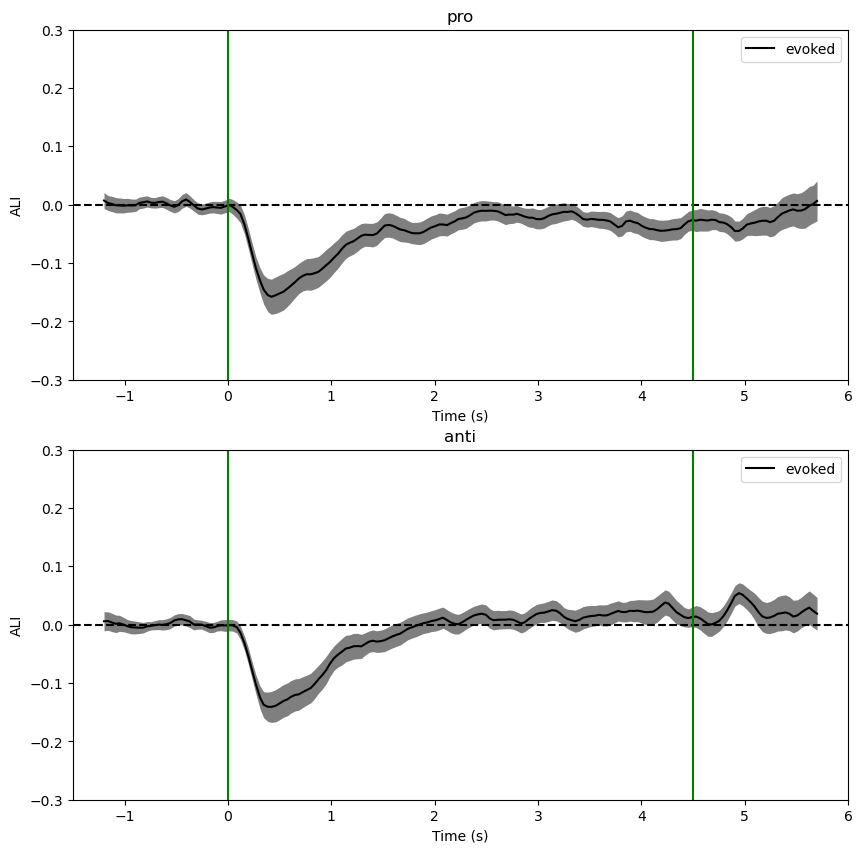

In [25]:
## ALIs for evoked vs induced for No TMS
lim_val = 0.3
f, axs = plt.subplots(2, 1, figsize=(10, 10))
cond = 0
block_types = ['pro', 'anti']
for jj, ax in zip(block_types, axs.ravel()):
    if jj == 'pro':
        tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 0) | (master_df['t_type'] == 1))]
    else:
        tdf = master_df[(master_df['istms'] == cond) & ((master_df['t_type'] == 2) | (master_df['t_type'] == 3))]

    low_thresh = np.quantile(tdf['ierr'], 0.25)
    high_thresh = np.quantile(tdf['ierr'], 0.75)
    if jj == 'pro':
        yin = ALI_evoked[cond, 0, :, :]
        yout = -ALI_evoked[cond, 1, :, :]
    else:
        yin = ALI_evoked[cond, 2, :, :]
        yout = -ALI_evoked[cond, 3, :, :]
    y_both = np.concatenate((yin, yout), axis=0)
    y_mean = np.nanmean(y_both, 0)
    y_err = np.nanstd(y_both, 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y_mean, 'k-', label='evoked')
    #ax.plot(time_array, y2, 'b-', label='induced')
    ax.fill_between(time_array[:,0], y_mean-y_err, y_mean+y_err, alpha=0.5, linewidth=0, color='k')
    #ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='b')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(jj)

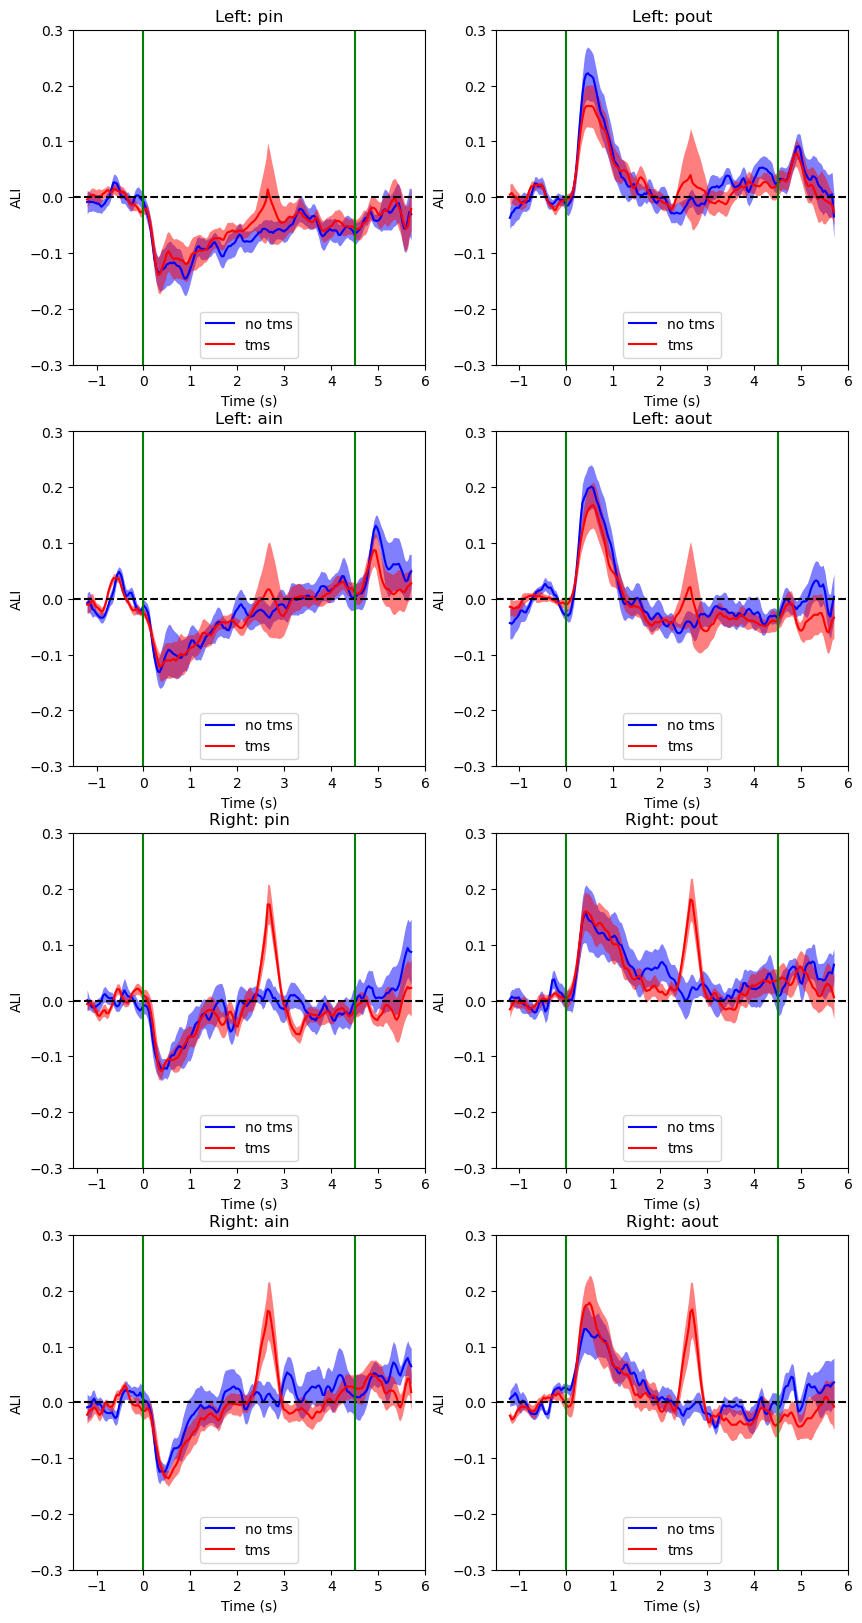

In [6]:
## ALIs for evoked for No TMS vs TMS
lim_val = 0.3
N = 8
cols = 2#int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))
f, axs = plt.subplots(rows, cols, figsize=(10, 20))
plt_counter = 0
for side in ['Left', 'Right']:
    for jj in [0, 1, 2, 3]:
        ax = axs[plt_counter // cols, plt_counter % cols]
        y1_holder = np.empty((0, ALI_evoked.shape[3]))
        y2_holder = np.empty((0, ALI_evoked.shape[3]))
        counter = 0
        for i, ss in enumerate(sub_list):
            if All_metadata[ss]['Hemisphere stimulated'] == side:
                slice_y1 = ALI_evoked[0, jj, i, :]
                slice_y2 = ALI_evoked[1, jj, i, :]
                y1_holder = np.concatenate((y1_holder, slice_y1[np.newaxis, :]), axis=0)
                y2_holder = np.concatenate((y2_holder, slice_y2[np.newaxis, :]), axis=0)
                counter += 1
        y1 = np.nanmean(y1_holder, 0)
        y2 = np.nanmean(y2_holder, 0)
        y1_err = np.nanstd(y1_holder, 0)/np.sqrt(counter)
        y2_err = np.nanstd(y2_holder, 0)/np.sqrt(counter)
        ax.plot(time_array, y1, 'b-', label='no tms')
        ax.plot(time_array, y2, 'r-', label='tms')
        ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='b')
        ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='r')
        ax.plot(time_array, np.zeros(len(time_array)), 'k--')
        ax.plot([0, 0], [-lim_val, lim_val], 'g-')
        ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
        ax.legend()
        ax.set_xlim(time_array[0], time_array[-1])
        ax.set_ylim(-lim_val, lim_val)
        ax.set_ylabel('ALI')
        ax.set_xlabel('Time (s)')
        ax.set_title(side + ': ' + trial_types[jj])
        plt_counter += 1

In [ ]:
## ALIs for evoked for No TMS vs TMS
lim_val = 0.5
N = 17*4
cols = 4#int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))
f, axs = plt.subplots(rows, cols, figsize=(20, 100))
plt_counter = 0
for i, ss in enumerate(sub_list):
    for jj in [0, 1, 2, 3]:
        ax = axs[plt_counter // cols, plt_counter % cols]
        y1 = ALI_induced[0, jj, i, :]
        y2 = ALI_induced[1, jj, i, :]

        ax.plot(time_array, y1, 'b-', label='no tms')
        ax.plot(time_array, y2, 'r-', label='tms')
        
        ax.plot(time_array, np.zeros(len(time_array)), 'k--')
        ax.plot([0, 0], [-lim_val, lim_val], 'g-')
        ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
        ax.legend()
        ax.set_xlim(time_array[0], time_array[-1])
        ax.set_ylim(-lim_val, lim_val)
        ax.set_ylabel('ALI')
        ax.set_xlabel('Time (s)')
        ax.set_title(str(ss) + ': ' + trial_types[jj])
        plt_counter += 1

## Decoding

In [ ]:
from sklearn.model_selection import KFold

idx_pin_ntms = master_df.loc[(master_df['istms']==0) & (master_df['t_type']==1)].index
mask = (time_array >= 0) & (time_array <= 4)
tidx = np.where(mask)[0]
X_temp = Xcommon_evoked[idx_pin_ntms, :]
X = X_temp[:, tidx]
this_df = master_df.iloc[idx_pin_ntms].reset_index(drop=True)
y = this_df['polang']

n_trials, n_timepoints = X.shape
mse_per_timepoint = np.zeros(n_timepoints) 

n_splits = 10
kf = KFold(n_splits=n_splits)

# Iterate over each time-point
for t in range(n_timepoints):
    y_preds = np.zeros(n_trials)
    y_true = y.copy()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index, t].reshape(-1, 1), X[test_index, t].reshape(-1, 1)
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_preds[test_index] = y_pred

    mse_per_timepoint[t] = mean_squared_error(y_true, y_preds)

n_permutations = 100
n_timepoints = X.shape[1]
perm_mse = np.zeros((n_permutations, n_timepoints))

for p in range(n_permutations):
    y_perm = np.random.permutation(y)
    for t in range(n_timepoints):
        y_preds = np.zeros(n_trials)
        y_true = y_perm.copy()

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index, t].reshape(-1, 1), X[test_index, t].reshape(-1, 1)
            y_train, y_test = y_perm[train_index], y_perm[test_index]

            model = LinearRegression()
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_preds[test_index] = y_pred

        perm_mse[p, t] = mean_squared_error(y_true, y_preds)
p_values = np.mean(perm_mse <= mse_per_timepoint, axis=0)

In [ ]:
time_array_relevant = time_array[tidx]
plt.figure(figsize=(10, 6))
plt.plot(time_array_relevant, mse_per_timepoint, marker='o')
plt.plot(time_array_relevant, np.mean(perm_mse, axis = 0), 'k--')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('MSE per Time-point')
plt.grid(True)
plt.show()

In [ ]:
this_df.columns

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC


idx_ntms = master_df.loc[(master_df['istms']==0) & (master_df['ispro']==1)].index
idx_ntms = master_df.loc[(master_df['ispro']==1)].index

mask = (time_array >= 0) & (time_array <= 4)
tidx = np.where(mask)[0]
X_temp = Xcommon_induced[idx_ntms, :]
X = X_temp[:, tidx]
this_df = master_df.iloc[idx_ntms].reset_index(drop=True)
y = this_df['TMS_time']
# pin_idx = np.where(y=='pro_intoVF')[0]
# pout_idx = np.where(y=='pro_outVF')[0]

# Xpin = X[pin_idx, :]
# Xpout = X[pout_idx, :]
# ypin = np.ones(len(pin_idx),)
# ypout = 1+np.ones(len(pout_idx),)
# X = np.concatenate((Xpin, Xpout), axis=0)
# y = np.concatenate((ypin, ypout), axis=0)

#y = 
#y = y.apply(lambda x: 1 if x in [1, 2] else 30)
n_trials, n_timepoints = X.shape
accuracy_per_timepoint = np.zeros(n_timepoints)

# loo = LeaveOneOut()
n_splits = 10
kf = KFold(n_splits=n_splits)

accuracy_per_timepoint = np.zeros(n_timepoints)

# Iterate over each time-point
for t in range(n_timepoints):
    y_preds = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index, t].reshape(-1, 1), X[test_index, t].reshape(-1, 1)
        y_train, y_test = y[train_index], y[test_index]

        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_preds.extend(model.predict(X_test))

    accuracy_per_timepoint[t] = accuracy_score(y, y_preds)

In [ ]:
y.unique()

In [ ]:
time_array_relevant = time_array[tidx]

plt.figure(figsize=(10, 6))
plt.plot(time_array_relevant, accuracy_per_timepoint, marker='o', label='Decoding Accuracy')
plt.axhline(y=0.25, color='k', linestyle='--', label='Chance Level (25%)')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Decoding Accuracy per Time-point')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
accuracy_matrix = np.zeros((n_timepoints, n_timepoints))
loo = LeaveOneOut()

# Loop over each time-point for training
for train_time in range(n_timepoints):
    X_train_time = X[:, train_time].reshape(-1, 1)

    # Loop over each time-point for testing
    for test_time in range(n_timepoints):
        y_preds = np.zeros(n_trials)
        X_test_time = X[:, test_time].reshape(-1, 1)

        for train_index, test_index in loo.split(X_train_time):
            model = LogisticRegression()
            model.fit(X_train_time[train_index], y[train_index])
            y_pred = model.predict(X_test_time[test_index])
            y_preds[test_index] = y_pred

        accuracy_matrix[train_time, test_time] = accuracy_score(y, y_preds)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, annot=True, cmap='viridis')
plt.xlabel('Test Time Point')
plt.ylabel('Train Time Point')
plt.title('Time-by-Time Generalization')
plt.show()

## Contralateral Delay Activity (CDA)

In [4]:
# Load up ALI evoked and induced
with h5py.File(p['mCDA'], 'r') as f:
    mCDA = np.array(f['mCDA']).T

with h5py.File(os.path.join(p['EEGfiles'], 'sub01/day01/sub01_day01_erp.mat')) as f:
    tarray_erp = np.array(f['ERP']['pin']['time'])

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/d/DATD/datd/MD_TMS_EEG/EEGfiles/CDA.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
## CDAs for evoked for No TMS vs TMS
lim_val = 2
N = 8
cols = 4#int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))
f, axs = plt.subplots(rows, cols, figsize=(20, 10))
plt_counter = 0
for tms_cond in [0, 1]:
    for jj in [0, 1, 2, 3]:
        ax = axs[plt_counter // cols, plt_counter % cols]
        y1_holder = np.empty((0, len(tarray_erp)))
        for i, ss in enumerate(sub_list):
            if tms_cond == 0:
                dd_idx = int(All_metadata[ss]['No TMS day']-1)
                y1 = mCDA[i, dd_idx, jj, :]
            else:
                nodd_idx = int(All_metadata[ss]['No TMS day']-1)
                dd_idx = [dd for dd in [0,1,2] if dd!=nodd_idx]
                y1 = np.mean(mCDA[i, dd_idx, jj, :], axis = 0)
            y1_holder = np.concatenate((y1_holder, y1[np.newaxis, :]), axis=0)
        y1_holder = np.nanmean(y1_holder, axis = 0)
        win_size = 20 #samples
        tarray_plot = np.convolve(tarray_erp[:, 0], np.ones(win_size)/win_size, mode='valid')
        y1_plot = np.convolve(y1_holder, np.ones(win_size)/win_size, mode='valid')
        if tms_cond == 0:
            ax.plot(tarray_plot, y1_plot, 'b-', label=tms_cond)  
        else:
            ax.plot(tarray_plot, y1_plot, 'r-', label=tms_cond)      
        ax.plot(tarray_plot, np.zeros(len(tarray_plot)), 'k--')
        ax.plot([0, 0], [-lim_val, lim_val], 'g-')
        ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
        ax.legend()
        ax.set_xlim(tarray_plot[0], tarray_plot[-1])
        ax.set_ylim(-lim_val, lim_val)
        ax.set_ylabel('CDA')
        ax.set_xlabel('Time (s)')
        ax.set_title('CDA: ' + trial_types[jj])
        plt_counter += 1